In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[MESSAGE] loading YOLO from disk...
The YOLO model took 0.165450 seconds


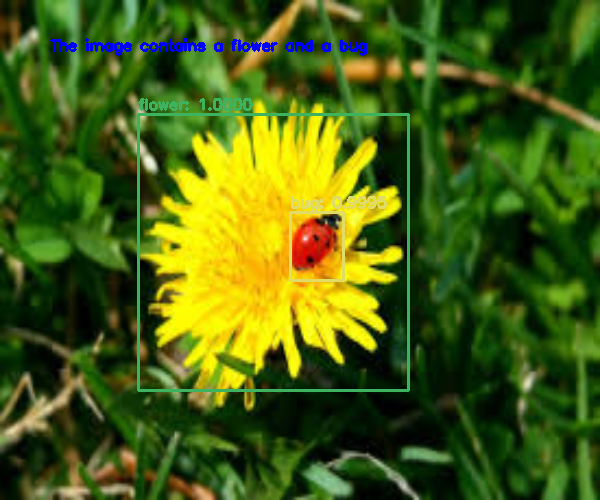

-1

In [49]:
#Import statements
#First it is neccessary to import all the required pakages
import numpy as np
import argparse
import time
import cv2
import os

#google colab required package
from google.colab import drive

# Next set the values for confidence and threshold
confidence = 0.5
threshold = 0.3

#Store values to determine if there are bugs/flowers in the image 
bugs = 0
flowers = 0

#Load the coco class labels that show all the avaliable classes that our YOLOv3 model was trained for.
drive.mount("/content/gdrive")
labelsPath = "gdrive/My Drive/BDG-Training/yolo-coco/coco.names"
LABELS = open(labelsPath).read().strip().split("\n")

# Initialize a list of colors to represent each posible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size =(len(LABELS), 3), dtype = "uint8")

#Derive the paths to the YOLO weights and model configuration. The weights is what we obtained after training. 
weightsPath = "gdrive/My Drive/BDG-Training/yolo-coco/yolov3.weights"
configPath = "gdrive/My Drive/BDG-Training/yolo-coco/yolov3.cfg"

#load our yolo object detector trained on COCO dataset
print("[MESSAGE] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

# Load our input image and grab its spatial dimentions
image = cv2.imread("gdrive/My Drive/BDG-Training/images/12.jpg")

image = cv2.resize(image,(600,500))
(H, W) = image.shape[:2]

# determine only the output layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector , giving us our bounding boxes and associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0 , (416,416), swapRB = True, crop = False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

# show the timing information on YOLO
print("The YOLO model took {:.6f} seconds".format(end - start))

# Initialize our list of detected bounding boxes, confidences, and class IDs, respectively
boxes = []
confidences = []
classIDs = []

# loop over each of the layer outputs
for output in layerOutputs:
    #loop over each of the detections
    for detection in output:
        #Its time to extract the class IDs and confidence of the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        #filter out the weak predictions by ensuring the detected probability is greater than the minimum probability
        if confidence > 0.80:

            # scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[0:4] * np.array([W,H,W,H])
            (centerX, centerY, width, height) = box.astype("int")

            # use the center (x, y)- coordinates to derive the top and left corner of the bounding box
            x = int(centerX - (width/2))
            y = int(centerY - (height / 2))

            #update our list of bounding box coordinates, confidences, and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

#apply non-maxima supression to supress weak and/or overlapping bounding boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence, threshold)

# ensure that at least one detection exists
if len(idxs) > 0:
    #loop over the indexes we are keeping
    for i in idxs.flatten():
        #extract the bounding box coordinates
        (x,y) = (boxes[i][0], boxes[i][1])
        (w,h) = (boxes[i][2], boxes[i][3])

        #draw a bounding box rectangle and label on the image.
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x,y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Check if it is a bug or flower
        if LABELS[classIDs[i]] == "bug":
          bugs = bugs + 1
        elif LABELS[classIDs[i]] == "flower":
          flowers = flowers + 1

#Now print out the message depending on if the what the image contains.
if bugs == 0 and flowers == 0:
  cv2.putText(image, "The image contains neither a bug nor a flower", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 2 )
elif bugs == 0 and flowers >= 1:
  cv2.putText(image, "The image contains a flower and no bug", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 2 )
elif bugs  >= 1 and flowers == 0:
  cv2.putText(image, "The image contains a bug and no flower", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 2 )
elif bugs >= 1 and flowers >= 1:
  cv2.putText(image, "The image contains a flower and a bug", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 2 )
          

#show the output image
from google.colab.patches import cv2_imshow
cv2_imshow(image)
cv2.waitKey(0)